<a href="https://colab.research.google.com/github/data-tamer2410/ds-accelerometer-activity-classification/blob/main/accelerometer_activity_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from zipfile import ZipFile
import seaborn as sns
import optuna
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report,f1_score,roc_auc_score
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict,cross_validate, StratifiedShuffleSplit, StratifiedKFold
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
%matplotlib inline

# Task.

According to the accelerometer data from the mobile phone, it is necessary to classify what kind of activity a person is engaged in: walking, standing, running or climbing stairs.

# Solving the task.

## Data preparation and loading.

In [3]:
with ZipFile('homework.zip', 'r') as f:
    f.extractall('.')

In [4]:
data = Path('data')
df = pd.DataFrame(columns=[
    'mean_X',
    'mean_Y',
    'mean_Z',
    'std_X',
    'std_Y',
    'std_Z',
    'targets'
    ])

res_el = pd.Series(index=[
    'mean_X',
    'mean_Y',
    'mean_Z',
    'std_X',
    'std_Y',
    'std_Z',
    'targets'
    ], dtype = object)

for dir in data.iterdir():
    targets = dir.name
    for obj in dir.iterdir():
        el = pd.read_csv(obj.absolute())
        res_el.loc[['mean_X', 'mean_Y', 'mean_Z']] = el.mean().values
        res_el.loc[['std_X','std_Y','std_Z']] = el.std().values
        res_el.loc['targets'] = targets
        df.loc[df.shape[0]] = res_el

df.head()

,mean_X,mean_Y,mean_Z,std_X,std_Y,std_Z,targets
0,0.450908,2.958755,8.689356,0.857834,3.095792,1.385434,idle
1,-0.246762,5.457663,7.920658,0.218239,0.219456,0.393433,idle
2,0.392011,-0.030167,9.75701,0.050594,0.052952,0.025007,idle
3,-0.097204,0.226013,9.766268,0.036013,0.022788,0.022093,idle
4,0.083478,4.68689,8.511068,0.468914,0.897268,0.542807,idle


The data is recorded over a certain period of time, so I calculate time signatures, for each chordant there is an average, and a standard deviation.

## Analysis data.

In [5]:
df.shape

(6462, 7)

In [6]:
df.isna().sum()

,0
mean_X,0
mean_Y,0
mean_Z,0
std_X,0
std_Y,0
std_Z,0
targets,0


In [7]:
df.duplicated().any()

False

In [8]:
df.drop(columns='targets').corr()

,mean_X,mean_Y,mean_Z,std_X,std_Y,std_Z
mean_X,1.000000,0.681804,0.148997,0.671501,0.628903,0.198499
mean_Y,0.681804,1.000000,0.311414,0.572934,0.584515,-0.024253
mean_Z,0.148997,0.311414,1.000000,-0.415652,-0.455825,-0.644718
std_X,0.671501,0.572934,-0.415652,1.000000,0.937052,0.641217
std_Y,0.628903,0.584515,-0.455825,0.937052,1.000000,0.620153
std_Z,0.198499,-0.024253,-0.644718,0.641217,0.620153,1.000000


In [9]:
df.describe()

,mean_X,mean_Y,mean_Z,std_X,std_Y,std_Z,targets
count,6462.000000,6462.000000,6462.000000,6462.00000,6462.00000,6462.000000,6462
unique,6397.000000,6430.000000,6370.000000,6458.00000,6460.00000,6462.000000,4
top,0.258255,-0.018196,9.768183,0.04153,0.01564,1.385434,running
freq,5.000000,2.000000,4.000000,2.00000,2.00000,1.000000,3408


In [10]:
df['targets'].value_counts()

,count
targets,
running,3408
walking,1850
idle,1039
stairs,165


There may be difficulties with the stairs class because there are very few instances of this class, the classes are not evenly distributed.

## Data visualization.

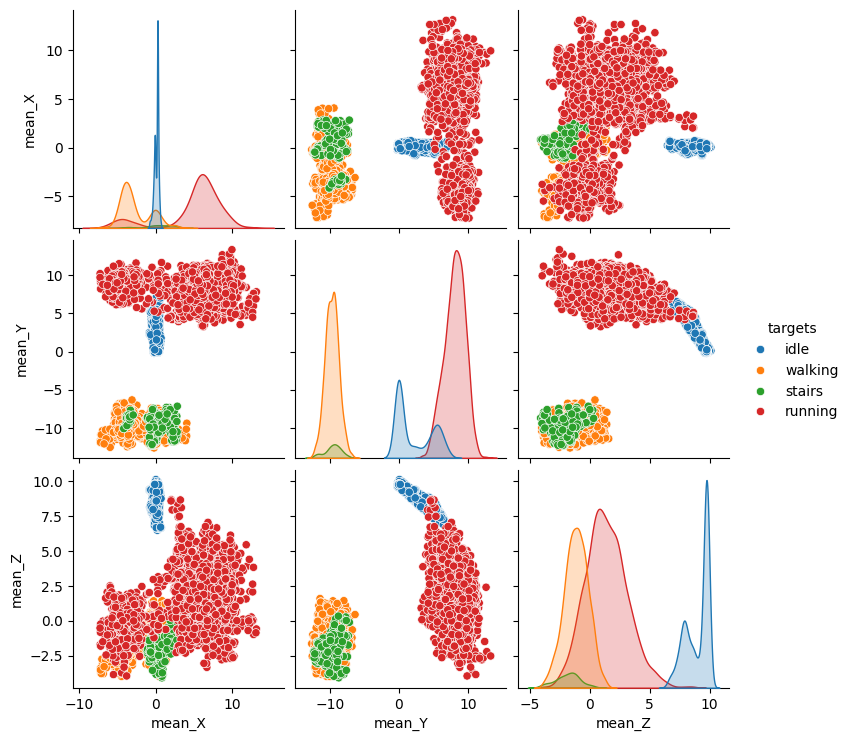

In [11]:
import warnings
warnings.filterwarnings('ignore')

data = df[['mean_X','mean_Y','mean_Z','targets']]
sns.pairplot(data,hue='targets')

The graph shows that the walking and stairs classes cannot be separated linearly, therefore linear classifiers such as Logistic Regression will not be suitable for solving this problem, we will use other classifiers.

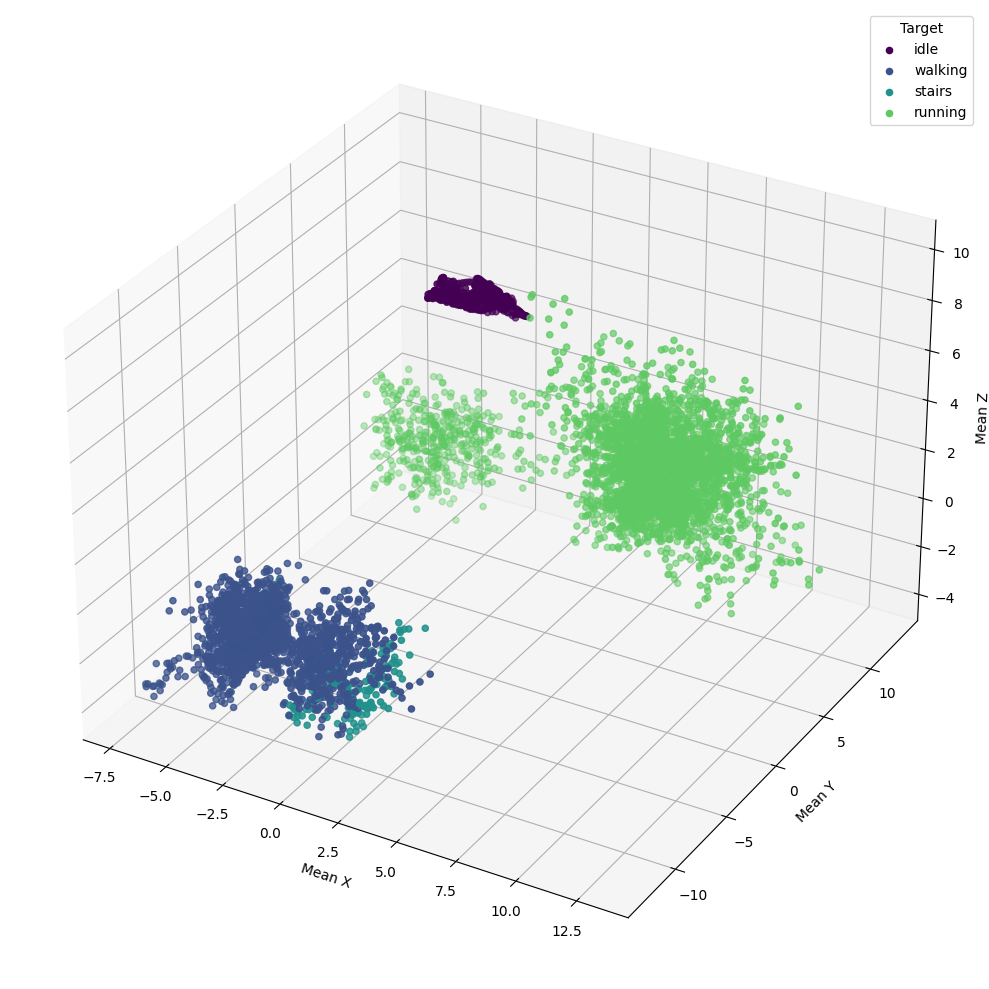

In [12]:
unique_targets = df['targets'].unique()
colors = {target: plt.cm.viridis(i / len(unique_targets)) for i, target in enumerate(unique_targets)}
point_colors = df['targets'].map(colors)
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')

ax.scatter(df['mean_X'],df['mean_Y'],df['mean_Z'],c=point_colors)

for target in unique_targets:
    ax.scatter([], [], [], color=colors[target], label=target)

ax.legend(title='Target')
ax.set_xlabel('Mean X')
ax.set_ylabel('Mean Y')
ax.set_zlabel('Mean Z')

plt.tight_layout()
plt.show()

## Coding of target values ​​and verification of feature mapping.

In [13]:
label_encoder = LabelEncoder()
df['targets'] = label_encoder.fit_transform(df['targets'])
target_names = label_encoder.classes_

0 - idle

1 - running

2 - stairs

3 - walking

In [14]:
features = df.drop(columns='targets')
targets = df['targets']

features.mean()

,0
mean_X,1.92355
mean_Y,1.598343
mean_Z,1.804896
std_X,6.150584
std_Y,8.417041
std_Z,5.688659


The features are slightly different in scale, it is better to standardize them.

## Standardization of features.

In [15]:
scaler = StandardScaler()
features = scaler.fit_transform(features)
features = pd.DataFrame(features, columns=scaler.feature_names_in_)

In [16]:
features.head()

,mean_X,mean_Y,mean_Z,std_X,std_Y,std_Z
0,-0.320669,0.169295,1.893279,-1.444238,-1.101927,-1.575216
1,-0.472588,0.480268,1.681881,-1.618765,-1.697560,-1.938343
2,-0.333494,-0.202658,2.186892,-1.664511,-1.732040,-2.073206
3,-0.440022,-0.170778,2.189438,-1.668489,-1.738287,-2.074273
4,-0.400678,0.384350,1.844248,-1.550363,-1.557199,-1.883664


## Separation of data into training and test data.

In [17]:
x_train, x_test, y_train, y_test = train_test_split(features,targets,test_size=0.25,random_state=1)

## Building models and quality assessment.

### SVC

SVC (Support Vector Classifier) is a classification algorithm based on the support vector machine (SVM) method. Its goal is to find an optimal boundary (hyperplane) between classes to separate the data with the largest possible margin (distance) between points from different classes that are closest to this boundary.

Since our data isn’t linearly separable, we'll use a non-linear kernel. Kernels allow the algorithm to transform features into a higher-dimensional space where the data may become linearly separable. For example, the RBF (Radial Basis Function) is a common non-linear kernel that helps create a more flexible decision boundary that better adapts to complex data patterns.

Thus, SVC with a non-linear kernel can find intricate, curved boundaries between classes. This is especially useful for activity classification from accelerometer data, where the classes might exhibit complex, overlapping patterns.

**Selection of hyperparameters using optuna.**

I run the tests several times, gradually reducing the range of parameters, in order to find the best parameters.

In [ ]:
def objective(trial):
    C = trial.suggest_float('C',100000,600000)
    kernel = trial.suggest_categorical('kernel',['rbf','poly'])

    model = SVC(C=C,kernel=kernel,class_weight='balanced',random_state=1)
    cv = StratifiedShuffleSplit(n_splits=10,test_size=0.25,random_state=1)

    score = cross_val_score(model,features,targets,scoring='f1_weighted',cv=cv)
    return score.mean()


study = optuna.create_study(direction='maximize',pruner=optuna.pruners.HyperbandPruner())
study.optimize(objective,n_trials=50,n_jobs=-1,show_progress_bar=True)

In [ ]:
print(f'Best params: {study.best_params}\nBest F1-weighted: {study.best_value}')

Best params: {'C': 545426.8239575288, 'kernel': 'poly'}
Best F1-weighted: 0.9968521415688473


In [18]:
svc = SVC(C=545426.8239575288,kernel='poly',class_weight='balanced',probability=True,random_state=1)

**CV test.**

In [19]:
cv = StratifiedKFold(n_splits=10,shuffle=True,random_state=10)
y_pred = cross_val_predict(svc,features,targets,cv=cv)
report_svc = classification_report(targets,y_pred,target_names=target_names)
print(report_svc)

              precision    recall  f1-score   support

        idle       1.00      1.00      1.00      1039
     running       1.00      1.00      1.00      3408
      stairs       0.91      0.92      0.91       165
     walking       0.99      0.99      0.99      1850

    accuracy                           1.00      6462
   macro avg       0.98      0.98      0.98      6462
weighted avg       1.00      1.00      1.00      6462



As we can see, the overall rating is almost perfect, but the stairs class has slightly lower ratings than other classes, this is due to the complex structure and small number of instances of this class.

In [20]:
cv = StratifiedShuffleSplit(n_splits=10,test_size=0.25,random_state=10)
scores = cross_validate(svc,features,targets,scoring=['f1_weighted','roc_auc_ovr_weighted'],cv=cv,n_jobs=-1,return_train_score=True)
scores_svc = {'F1-weighted':scores['test_f1_weighted'].mean(),'ROC-AUC-weighted':scores['test_roc_auc_ovr_weighted'].mean()}

print('CV testing:')
for score,value in scores_svc.items():
    print(f'{score}: {value}')

CV testing:
F1-weighted: 0.996004656691363
ROC-AUC-weighted: 0.9999297910090847


Let's look at the cross-validation estimates on the training data.

In [21]:
print('CV testing on training data:')
print(f'F1-weighted: {scores["train_f1_weighted"].mean()}\nROC-AUC-weighted: {scores["train_roc_auc_ovr_weighted"].mean()}')

CV testing on training data:
F1-weighted: 0.9998352171229046
ROC-AUC-weighted: 0.9999999868897232


**Control test.**

In [22]:
svc.fit(x_train,y_train)
y_pred = svc.predict(x_test)
y_proba = svc.predict_proba(x_test)

print(f'Control test:\nF1-weighted: {f1_score(y_test,y_pred,average="weighted")}\n'
      f'ROC-AUC-weighted: {roc_auc_score(y_test,y_proba,multi_class="ovr",average="weighted")}')

Control test:
F1-weighted: 0.9956056147279914
ROC-AUC-weighted: 0.9998705560136937


**Visualization of the model work.**

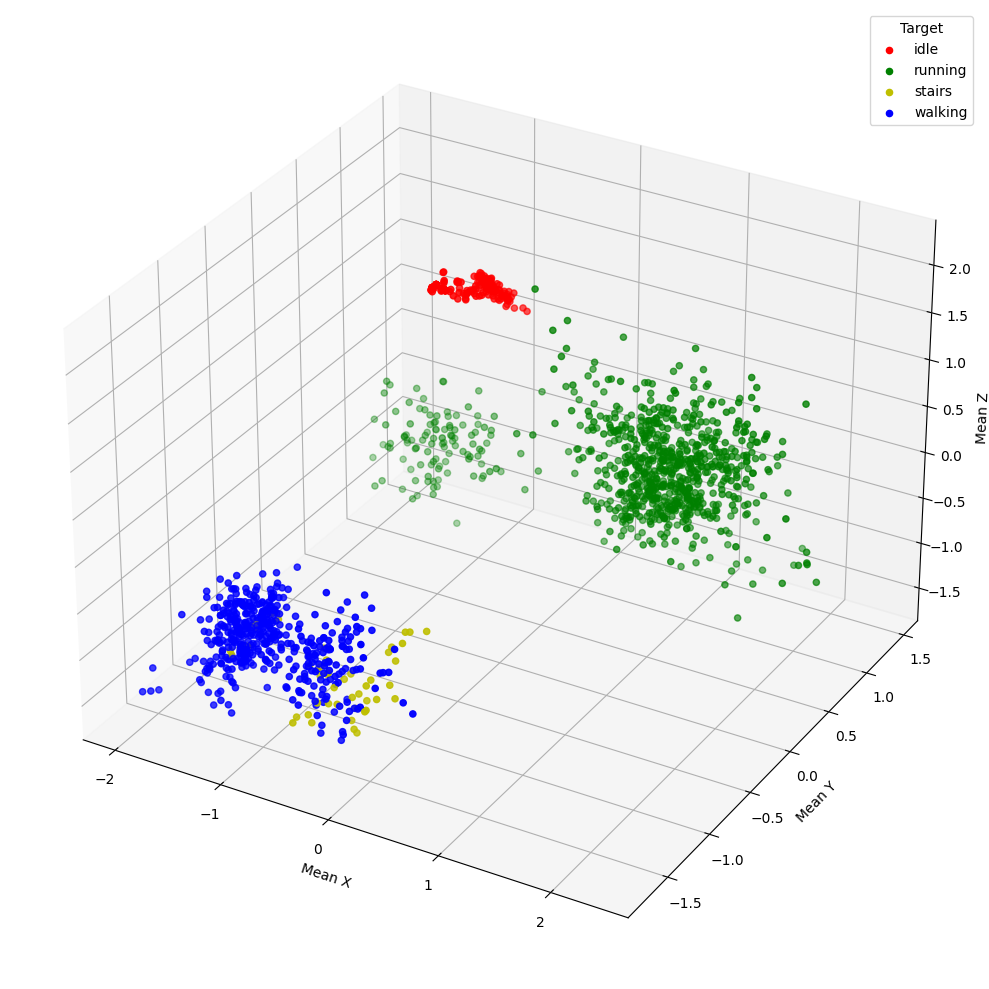

In [23]:
colors_pallete= {0:'r',1:'g',2:'y',3:'b'}
colors = pd.Series(y_pred).apply(lambda x: colors_pallete[x])

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')

ax.scatter(x_test['mean_X'],x_test['mean_Y'],x_test['mean_Z'],c=colors)

for c ,target in zip(colors_pallete.values(),target_names):
    ax.scatter([], [], [],c=c, label=target)

ax.legend(title='Target')
ax.set_xlabel('Mean X')
ax.set_ylabel('Mean Y')
ax.set_zlabel('Mean Z')

plt.tight_layout()
plt.show()

###RandomForest


The next algorithm we will examine is the Random Forest Classifier. This ensemble learning method combines multiple decision trees to improve classification accuracy and reduce the risk of overfitting. Each tree in the forest is trained on a random subset of the data, and the final prediction is made by majority voting from all trees. Random Forest is known for its robustness, ability to handle missing values, and feature importance evaluation, making it a popular choice for various classification tasks.

**Selection of hyperparameters using optuna.**

I run the tests several times, gradually reducing the range of parameters, in order to find the best parameters.

In [ ]:
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators',700,730)
    max_depth = trial.suggest_int('max_depth',25,30)
    min_samples_leaf = trial.suggest_int('min_samples_leaf',2,4)
    min_samples_split = trial.suggest_int('min_samples_split',5,9)
    max_features = trial.suggest_int('max_features',1,3)
    max_samples = trial.suggest_float('max_samples',0.735,0.745)

    model = RandomForestClassifier(n_estimators=n_estimators,
                                   max_depth=max_depth,
                                   min_samples_leaf=min_samples_leaf,
                                   min_samples_split=min_samples_split,
                                   max_features=max_features,
                                   max_samples=max_samples,
                                   class_weight='balanced',
                                   random_state=1,n_jobs=-1)

    cv = StratifiedShuffleSplit(n_splits=10,test_size=0.25,random_state=1)
    score = cross_val_score(model,features,targets,scoring='f1_weighted',cv=cv,n_jobs=-1)
    return score.mean()

study = optuna.create_study(direction='maximize',pruner=optuna.pruners.HyperbandPruner())
study.optimize(objective,n_trials=50,n_jobs=-1,show_progress_bar=True)

In [ ]:
print(f'Best params: {study.best_params}\nBest F1-weighted: {study.best_value}')

Best params: {'n_estimators': 714, 'max_depth': 28, 'min_samples_leaf': 2, 'min_samples_split': 9, 'max_features': 1, 'max_samples': 0.7449016773557497}
Best F1-weighted: 0.9972850991609793


In [24]:
rf = RandomForestClassifier(n_estimators=714,
                            max_depth=28,
                            min_samples_leaf=2,
                            min_samples_split=9,
                            max_features=1,
                            max_samples=0.7449016773557497,
                            class_weight='balanced',
                            random_state=1,n_jobs=-1)

**CV test.**

In [25]:
cv = StratifiedKFold(n_splits=10,shuffle=True,random_state=10)
y_pred = cross_val_predict(rf,features,targets,cv=cv)
report_rf = classification_report(targets,y_pred,target_names=target_names)
print(report_rf)

              precision    recall  f1-score   support

        idle       1.00      1.00      1.00      1039
     running       1.00      1.00      1.00      3408
      stairs       0.97      0.92      0.95       165
     walking       0.99      1.00      1.00      1850

    accuracy                           1.00      6462
   macro avg       0.99      0.98      0.99      6462
weighted avg       1.00      1.00      1.00      6462



In [26]:
cv = StratifiedShuffleSplit(n_splits=10,test_size=0.25,random_state=10)
scores = cross_validate(rf,features,targets,scoring=['f1_weighted','roc_auc_ovr_weighted'],cv=cv,n_jobs=-1,return_train_score=True)
scores_rf = {'F1-weighted':scores['test_f1_weighted'].mean(),'ROC-AUC-weighted':scores['test_roc_auc_ovr_weighted'].mean()}

print('CV testing:')
for score,value in scores_rf.items():
    print(f'{score}: {value}')

CV testing:
F1-weighted: 0.9966381337613619
ROC-AUC-weighted: 0.9999317629538943


In [27]:
print('CV testing on training data:')
print(f'F1-weighted: {scores["train_f1_weighted"].mean()}\nROC-AUC-weighted: {scores["train_roc_auc_ovr_weighted"].mean()}')

CV testing on training data:
F1-weighted: 0.9996489278178459
ROC-AUC-weighted: 0.9999997420205284


**Control test.**

In [28]:
rf.fit(x_train,y_train)
y_pred = rf.predict(x_test)
y_proba = rf.predict_proba(x_test)

print(f'Control test:\nF1-weighted: {f1_score(y_test,y_pred,average="weighted")}\n'
      f'ROC-AUC-weighted: {roc_auc_score(y_test,y_proba,multi_class="ovr",average="weighted")}')

Control test:
F1-weighted: 0.9968294484763459
ROC-AUC-weighted: 0.9998757746215001


**The most significant features.**

In [29]:
rf.feature_importances_

array([0.17939729, 0.1611361 , 0.13339254, 0.16118709, 0.19018341,
       0.17470357])

**Visualization of the model work.**

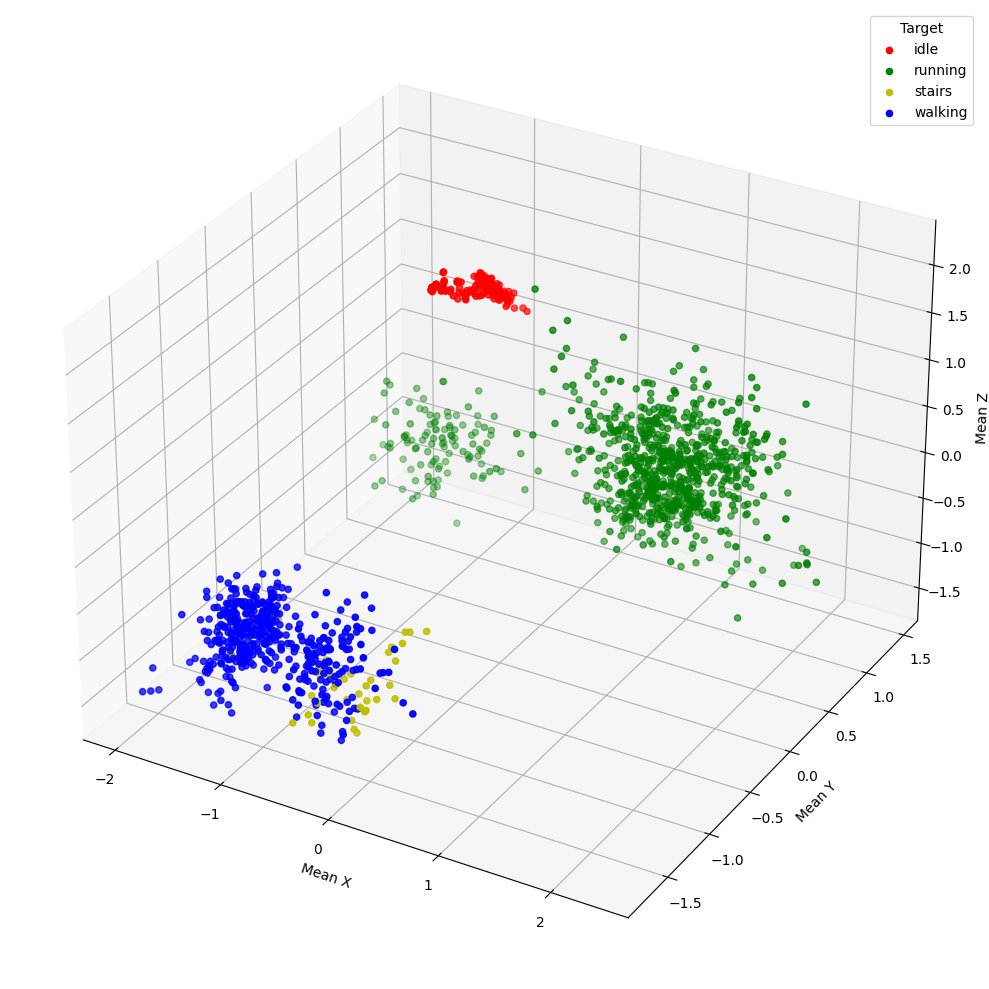

In [30]:
colors_pallete= {0:'r',1:'g',2:'y',3:'b'}
colors = pd.Series(y_pred).apply(lambda x: colors_pallete[x])

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')

ax.scatter(x_test['mean_X'],x_test['mean_Y'],x_test['mean_Z'],c=colors)

for c ,target in zip(colors_pallete.values(),target_names):
    ax.scatter([], [], [],c=c, label=target)

ax.legend(title='Target')
ax.set_xlabel('Mean X')
ax.set_ylabel('Mean Y')
ax.set_zlabel('Mean Z')

plt.tight_layout()
plt.show()

### KNeighbors

The k-Nearest Neighbors (k-NN) algorithm is a classification method that assigns a new data point to the class most common among its *k* nearest neighbors. In this algorithm, data points are classified based on their "proximity" to other points, typically using Euclidean distance, though other distance metrics can also be used.

To make a prediction, k-NN:
1. Finds the *k* closest neighbors in the training set.
2. Determines the most frequent class among these neighbors.
3. Assigns the new data point to this majority class.

k-NN is a simple yet powerful method, especially effective when data clusters are clearly separated. However, it can be sensitive to the "curse of dimensionality" and requires substantial memory to store all training data points.

**Selection of hyperparameters using optuna.**

In [ ]:
def objective(trial):
    n_neighbors = trial.suggest_int('n_neighbors',1,100)

    model = KNeighborsClassifier(n_neighbors=n_neighbors,n_jobs=-1)

    cv = StratifiedShuffleSplit(n_splits=10,test_size=0.25,random_state=1)
    score = cross_val_score(model,features,targets,scoring='f1_weighted',cv=cv,n_jobs=-1)
    return score.mean()

study = optuna.create_study(direction='maximize',pruner=optuna.pruners.HyperbandPruner())
study.optimize(objective,n_trials=50,n_jobs=-1,show_progress_bar=True)

In [ ]:
print(f'Best params: {study.best_params}\nBest F1-weighted: {study.best_value}')

Best params: {'n_neighbors': 1}
Best F1-weighted: 0.9982603892434806')


In [31]:
knn = KNeighborsClassifier(n_neighbors=1)

**CV test.**

In [32]:
cv = StratifiedKFold(n_splits=10,shuffle=True,random_state=10)
y_pred = cross_val_predict(knn,features,targets,cv=cv)
report_knn = classification_report(targets,y_pred,target_names=target_names)
print(report_knn)

              precision    recall  f1-score   support

        idle       1.00      1.00      1.00      1039
     running       1.00      1.00      1.00      3408
      stairs       0.98      0.97      0.98       165
     walking       1.00      1.00      1.00      1850

    accuracy                           1.00      6462
   macro avg       0.99      0.99      0.99      6462
weighted avg       1.00      1.00      1.00      6462



As we can see, this algorithm works flawlessly with n_neighbors = 1, which indicates that the data has very little or no noise at all.

In [45]:
cv = StratifiedShuffleSplit(n_splits=10,test_size=0.25,random_state=10)
scores = cross_validate(knn,features,targets,scoring=['f1_weighted','roc_auc_ovr_weighted'],cv=cv,n_jobs=-1,return_train_score=True)
scores_knn = {'F1-weighted':scores['test_f1_weighted'].mean(),'ROC-AUC-weighted':scores['test_roc_auc_ovr_weighted'].mean()}

print('CV testing:')
for score,value in scores_knn.items():
    print(f'{score}: {value}')

CV testing:
F1-weighted: 0.9986424962103694
ROC-AUC-weighted: 0.9991970153774143


In [33]:
print('CV testing on training data:')
print(f'F1-weighted: {scores["train_f1_weighted"].mean()}\nROC-AUC-weighted: {scores["train_roc_auc_ovr_weighted"].mean()}')

CV testing on training data:
F1-weighted: 0.9996489278178459
ROC-AUC-weighted: 0.9999997420205284


**Control test.**

In [34]:
knn.fit(x_train,y_train)
y_pred = knn.predict(x_test)
y_proba = knn.predict_proba(x_test)

print(f'Control test:\nF1-weighted: {f1_score(y_test,y_pred,average="weighted")}\n'
      f'ROC-AUC-weighted: {roc_auc_score(y_test,y_proba,multi_class="ovr",average="weighted")}')

Control test:
F1-weighted: 0.9981348192975739
ROC-AUC-weighted: 0.9988220159197699


**Visualization of the model work.**

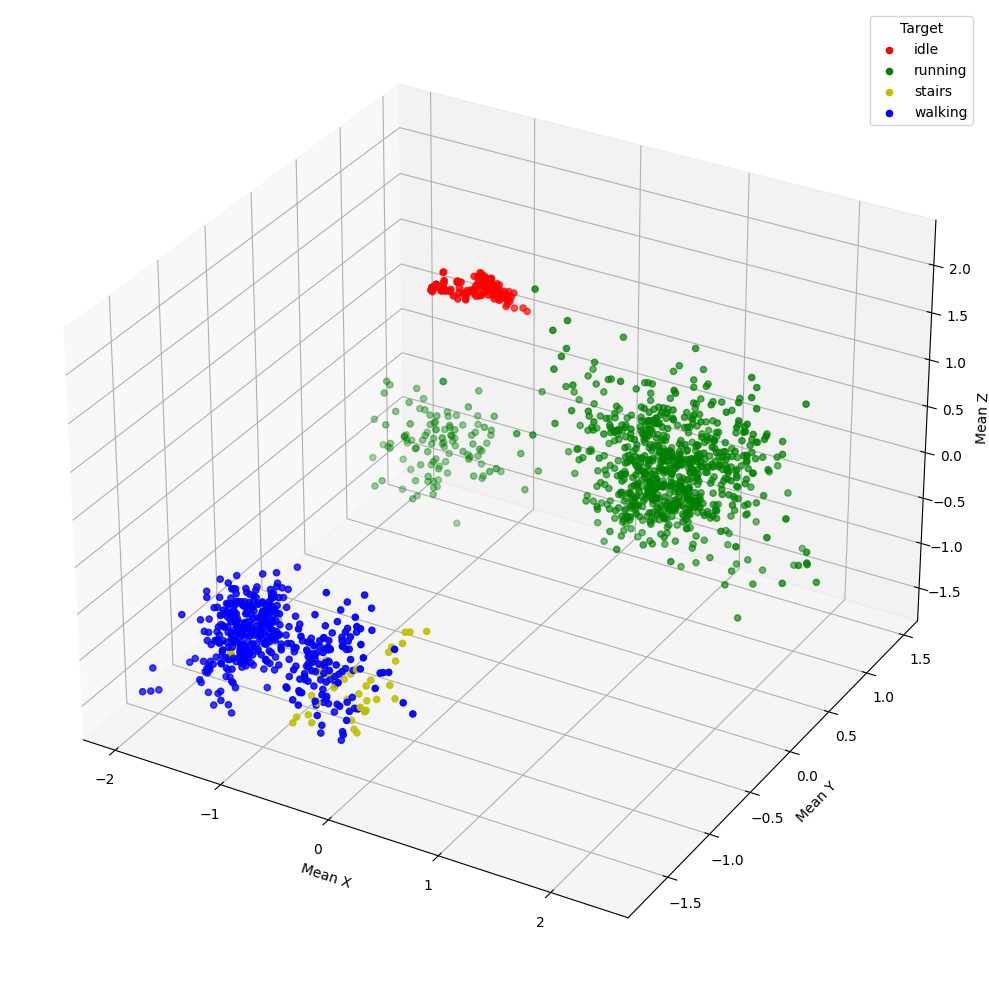

In [35]:
colors_pallete= {0:'r',1:'g',2:'y',3:'b'}
colors = pd.Series(y_pred).apply(lambda x: colors_pallete[x])

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')

ax.scatter(x_test['mean_X'],x_test['mean_Y'],x_test['mean_Z'],c=colors)

for c ,target in zip(colors_pallete.values(),target_names):
    ax.scatter([], [], [],c=c, label=target)

ax.legend(title='Target')
ax.set_xlabel('Mean X')
ax.set_ylabel('Mean Y')
ax.set_zlabel('Mean Z')

plt.tight_layout()
plt.show()

### GradientBoostingClassifier

**Gradient Boosting** is an ensemble learning method used to build a strong model from multiple weak learners (typically decision trees). The key idea is to add new models that correct the errors of previous models. Gradient boosting builds these models sequentially, with each new model "fitting" to the residuals or errors of the previous ones using gradient information to minimize the loss function. This method is widely used for both classification and regression tasks and can improve model accuracy significantly, especially on complex datasets.

**Main steps in Gradient Boosting**:
1. Build an initial base model (such as a decision tree).
2. Evaluate the errors of the base model.
3. Add new models to reduce the remaining errors.
4. Repeat until reaching the desired accuracy or the maximum number of iterations.


**Selection of hyperparameters using optuna.**

I run the tests several times, gradually reducing the range of parameters, in order to find the best parameters.

In [ ]:
def objective(trial):
    learning_rate = trial.suggest_float('learning_rate',0.00001,1.0)
    n_estimators = trial.suggest_int('n_estimators',10,1000)
    subsample = trial.suggest_float('subsample',0.1,1.0)
    min_samples_leaf = trial.suggest_int('min_samples_leaf',1,10)
    min_samples_split = trial.suggest_int('min_samples_split',2,10)
    max_depth = trial.suggest_int('max_depth',1,100)
    max_features = trial.suggest_int('max_features',1,features.shape[1])

    model = GradientBoostingClassifier(learning_rate=learning_rate,
                                       n_estimators=n_estimators,
                                       subsample=subsample,
                                       min_samples_leaf=min_samples_leaf,
                                       min_samples_split=min_samples_split,
                                       max_depth=max_depth,
                                       max_features=max_features,
                                       random_state=1)
    cv = StratifiedShuffleSplit(n_splits=10,test_size=0.25,random_state=1)
    score = cross_val_score(model,features,targets,scoring='f1_weighted',cv=cv,n_jobs=-1)
    return score.mean()

study = optuna.create_study(direction='maximize',pruner=optuna.pruners.HyperbandPruner())
study.optimize(objective,n_trials=50,n_jobs=-1,show_progress_bar=True)

In [36]:
print(f'Best params: {study.best_params}\nBest F1-weighted: {study.best_value}')

Best params: {'learning_rate': 0.12833710699809456, 'n_estimators': 811, 'subsample': 0.8078764761671595, 'min_samples_leaf': 10, 'min_samples_split': 2, 'max_depth': 30, 'max_features': 2}
Best F1-weighted: 0.9976450885810608


In [37]:
gb = GradientBoostingClassifier(learning_rate=0.12833710699809456,
                                n_estimators=811,
                                subsample=0.8078764761671595,
                                min_samples_leaf=10,
                                min_samples_split=2,
                                max_depth=30,
                                max_features=2,
                                random_state=1)

**CV test.**

In [38]:
cv = StratifiedKFold(n_splits=10,shuffle=True,random_state=10)
y_pred = cross_val_predict(gb,features,targets,cv=cv)
report_gb = classification_report(targets,y_pred,target_names=target_names)
print(report_gb)

              precision    recall  f1-score   support

        idle       1.00      1.00      1.00      1039
     running       1.00      1.00      1.00      3408
      stairs       0.99      0.92      0.95       165
     walking       0.99      1.00      1.00      1850

    accuracy                           1.00      6462
   macro avg       1.00      0.98      0.99      6462
weighted avg       1.00      1.00      1.00      6462



In [39]:
cv = StratifiedShuffleSplit(n_splits=10,test_size=0.25,random_state=10)
scores = cross_validate(gb,features,targets,scoring=['f1_weighted','roc_auc_ovr_weighted'],cv=cv,n_jobs=-1,return_train_score=True)
scores_gb = {'F1-weighted':scores['test_f1_weighted'].mean(),'ROC-AUC-weighted':scores['test_roc_auc_ovr_weighted'].mean()}

print('CV testing:')
for score,value in scores_gb.items():
    print(f'{score}: {value}')

CV testing:
F1-weighted: 0.9976120125228087
ROC-AUC-weighted: 0.9999237845665375


In [40]:
print('CV testing on training data:')
print(f'F1-weighted: {scores["train_f1_weighted"].mean()}\nROC-AUC-weighted: {scores["train_roc_auc_ovr_weighted"].mean()}')

CV testing on training data:
F1-weighted: 1.0
ROC-AUC-weighted: 1.0


**Control test.**

In [41]:
gb.fit(x_train,y_train)
y_pred = gb.predict(x_test)
y_proba = gb.predict_proba(x_test)

print(f'Control test:\nF1-weighted: {f1_score(y_test,y_pred,average="weighted")}\n'
      f'ROC-AUC-weighted: {roc_auc_score(y_test,y_proba,multi_class="ovr",average="weighted")}')

Control test:
F1-weighted: 0.996175606571646
ROC-AUC-weighted: 0.9997776924609539


**Visualization of the model work.**

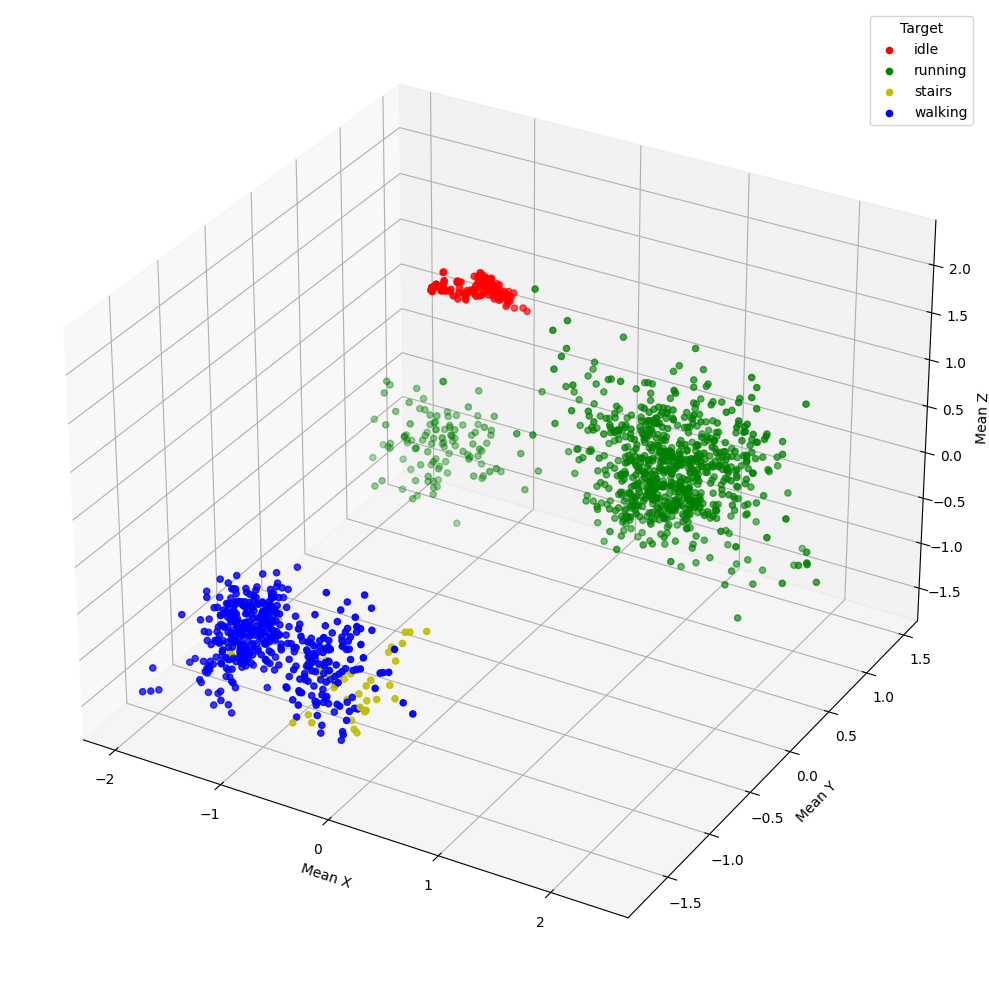

In [42]:
colors_pallete= {0:'r',1:'g',2:'y',3:'b'}
colors = pd.Series(y_pred).apply(lambda x: colors_pallete[x])

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')

ax.scatter(x_test['mean_X'],x_test['mean_Y'],x_test['mean_Z'],c=colors)

for c ,target in zip(colors_pallete.values(),target_names):
    ax.scatter([], [], [],c=c, label=target)

ax.legend(title='Target')
ax.set_xlabel('Mean X')
ax.set_ylabel('Mean Y')
ax.set_zlabel('Mean Z')

plt.tight_layout()
plt.show()

## Comparison of the quality of algorithms.

In [53]:
algo_names = ('SVC','RandomForest','KNeighbors','GradientBoosting')
all_reports = (report_svc,report_rf,report_knn,report_gb)

for algo,rep in zip(algo_names,all_reports):
    print(f'{algo}:\n{rep}\n{"-" * 53}')

SVC:
              precision    recall  f1-score   support

        idle       1.00      1.00      1.00      1039
     running       1.00      1.00      1.00      3408
      stairs       0.91      0.92      0.91       165
     walking       0.99      0.99      0.99      1850

    accuracy                           1.00      6462
   macro avg       0.98      0.98      0.98      6462
weighted avg       1.00      1.00      1.00      6462

-----------------------------------------------------
RandomForest:
              precision    recall  f1-score   support

        idle       1.00      1.00      1.00      1039
     running       1.00      1.00      1.00      3408
      stairs       0.97      0.92      0.95       165
     walking       0.99      1.00      1.00      1850

    accuracy                           1.00      6462
   macro avg       0.99      0.98      0.99      6462
weighted avg       1.00      1.00      1.00      6462

-----------------------------------------------------
KNe

In [54]:
all_cv_scores = (scores_svc,scores_rf,scores_knn,scores_gb)

all_f1_weighted= [scores['F1-weighted'] for scores in all_cv_scores]
all_roc_auc_weighted = [scores['ROC-AUC-weighted'] for scores in all_cv_scores]

for algo,f1_weighted,roc_auc_weighted in zip(algo_names,all_f1_weighted,all_roc_auc_weighted):
    print(f'{algo}:\nF1-weighted: {f1_weighted}\nROC-AUC-weighted: {roc_auc_weighted}\n')

SVC:
F1-weighted: 0.996004656691363
ROC-AUC-weighted: 0.9999297910090847

RandomForest:
F1-weighted: 0.9966381337613619
ROC-AUC-weighted: 0.9999317629538943

KNeighbors:
F1-weighted: 0.9986424962103694
ROC-AUC-weighted: 0.9991970153774143

GradientBoosting:
F1-weighted: 0.9976120125228087
ROC-AUC-weighted: 0.9999237845665375



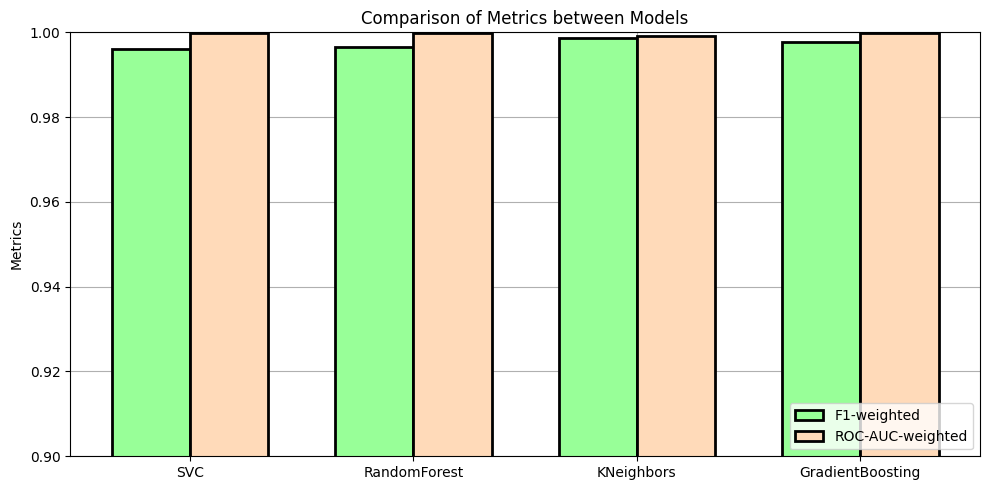

In [55]:
plt.figure(figsize=(10,5))

x = np.arange(0,len(algo_names))
width = 0.35

plt.bar(x - width / 2, height=all_f1_weighted,width=width,color='#98FF98',edgecolor='black',linewidth=2,label='F1-weighted',zorder=2)
plt.bar(x + width / 2, height=all_roc_auc_weighted,width=width,color='#FFDAB9',edgecolor='black',linewidth=2,label='ROC-AUC-weighted',zorder=2)


plt.title('Comparison of Metrics between Models')
plt.ylabel('Metrics')
plt.xticks(x,algo_names)
plt.ylim(0.9,1.0)

plt.legend(loc='lower right')
plt.tight_layout()
plt.grid(zorder=1)
plt.show()

# Conclusion.

The results demonstrated that all models performed exceptionally well, achieving near-perfect classification accuracy. The k-NN model exhibited the best overall performance, while ensemble methods like Random Forest and Gradient Boosting offered robust generalization capabilities. Despite the challenges posed by the imbalanced dataset, particularly for the stairs activity, the project illustrates the effectiveness of using machine learning for real-time human activity recognition.